<a href="https://colab.research.google.com/github/bobyuwono/Sign-Language-Game/blob/master/ASL_classifier_V3%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras

from keras import layers
import numpy as np


Using TensorFlow backend.


In [2]:
# ensure consistency across runs
from numpy.random import seed
seed(2)
tf.random.set_seed(2)

# Dataset

In [3]:
#install dependencies
!pip install kaggle

In [4]:
#upload kaggle account credentials
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bobyuwono","key":"9926919560abed66245d90b2cd8e67ec"}'}

In [5]:
# the kaggle API client expects this file to be in ~/.kaggle
!mkdir -p ~/.kaggle
!cp  kaggle.json ~/.kaggle/

# this permission change avoids a warning on kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

#import dataset
!kaggle datasets download -d grassknoted/asl-alphabet

!ls

 99% 1.02G/1.03G [00:28<00:00, 33.3MB/s]
100% 1.03G/1.03G [00:28<00:00, 38.0MB/s]
asl-alphabet.zip  kaggle.json  sample_data


In [6]:
import os
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing191.jpg  
  inflating: asl_alphabet_t

Samples images for letter C


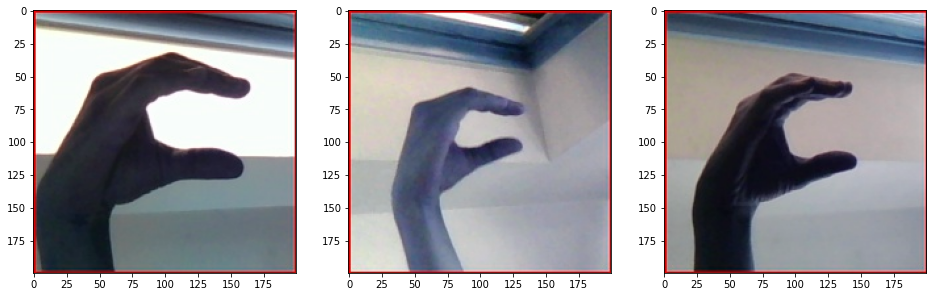

In [9]:
# Imports to view data
import cv2
from glob import glob
from matplotlib import pyplot as plt
from numpy import floor
import random

def plot_three_samples(letter):
    print("Samples images for letter " + letter)
    base_path = 'asl_alphabet_train/asl_alphabet_train/'
    img_path = base_path + letter + '/**'
    path_contents = glob(img_path)
    
    plt.figure(figsize=(16,16))
    imgs = random.sample(path_contents, 3)
    plt.subplot(131)
    plt.imshow(cv2.imread(imgs[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(imgs[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(imgs[2]))
    return

plot_three_samples("C")

In [10]:
from keras.preprocessing.image import ImageDataGenerator

data_dir = "asl_alphabet_train/asl_alphabet_train"
target_size = (60,60)
target_dims = (60,60, 3) # add channel for RGB
n_classes = 29
val_frac = 0.1
batch_size = 32

data_augmentor = ImageDataGenerator(samplewise_center=True, 
                                    samplewise_std_normalization=True, 
                                    validation_split=val_frac)

train_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, shuffle=True, subset="training")
val_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, subset="validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [11]:
cls_train = train_generator.classes

In [12]:
class_names = list(train_generator.class_indices.keys())
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [13]:
print(cls_train)

[ 0  0  0 ... 28 28 28]


In [14]:
#checking if each class weight is balanced
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)
class_weight

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Transfer Learning with VGG16 Model

In [15]:
from keras.applications.vgg16 import VGG16

pre_trained_model = VGG16(include_top=False,weights='imagenet', input_shape=(60,60,3))

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 60, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 60, 60, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 60, 60, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 30, 30, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 30, 30, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 30, 30, 128)       147584    
______________________________________________________________

In [16]:
last_layer = pre_trained_model.get_layer('block4_conv3')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 512)


In [17]:
from keras import Model
from keras.optimizers import Adam, RMSprop
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(29, activation = 'softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = Adam(lr=1e-7), 
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])

In [19]:
history = model.fit_generator(train_generator, epochs=30, validation_data=val_generator)

Epoch 1/30
2447/2447 [==============================] - 131s 53ms/step - loss: 0.5434 - accuracy: 0.8345 - val_loss: 0.4721 - val_accuracy: 0.7262
Epoch 2/30
2447/2447 [==============================] - 129s 53ms/step - loss: 0.5091 - accuracy: 0.8447 - val_loss: 0.6080 - val_accuracy: 0.7341
Epoch 3/30
2447/2447 [==============================] - 130s 53ms/step - loss: 0.4728 - accuracy: 0.8568 - val_loss: 0.9743 - val_accuracy: 0.7393
Epoch 4/30
2447/2447 [==============================] - 130s 53ms/step - loss: 0.4417 - accuracy: 0.8664 - val_loss: 0.9285 - val_accuracy: 0.7468
Epoch 5/30
2447/2447 [==============================] - 130s 53ms/step - loss: 0.4102 - accuracy: 0.8757 - val_loss: 0.5896 - val_accuracy: 0.7526
Epoch 6/30
2447/2447 [==============================] - 129s 53ms/step - loss: 0.3866 - accuracy: 0.8833 - val_loss: 0.8126 - val_accuracy: 0.7577
Epoch 7/30
2447/2447 [==============================] - 129s 53ms/step - loss: 0.3623 - accuracy: 0.8913 - val_loss: 0

# Predicting session 
belum dicoba*


In [31]:
# upload image to be predicted
from google.colab import files
files.upload()

Saving C_test.jpg to C_test (1).jpg


{'C_test.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00\xc8\x00\xc8\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x

In [38]:
#helper function to predict
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(target_size, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array)

    print(pred)
    pred.type()

    # # Decode the output of the VGG16 model.
    # pred_decoded = decode_predictions(pred)[0]

    # # Print the predictions.
    # for code, name, score in pred_decoded:
    #     print("{0:>6.2%} : {1}".format(score, name))

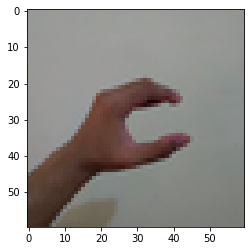

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]


AttributeError: ignored

In [39]:
predict(image_path='test_c_2.jpg')